## Import Libraries

In [1]:
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 100)

import matplotlib.pyplot as plt
import pandas_datareader as wb
import datetime as dt
import numpy as np

## Set Parameters

In [2]:
ticker = 'SPY'
start = '2000-01-01'
end = None

# stochastic params
lookback = 9
k_period = 3
d_period = 3
oversold = 20
overbought = 80

# moving average params
fast_ema = 20
slow_ema = 40
sign_ema = 3

# momentum param
momentum = 200

## Retrieve and Manipulate Daily Data

In [3]:
# fetch daily data
daily = wb.DataReader(ticker, 'yahoo', start, end)[['Open','High','Low','Close']]

# compute daily momentum
daily['Momentum'] = daily['Close'].pct_change(momentum)
daily['Momentum'] = daily['Momentum'].apply(lambda x: 1 if x > 0 else \
                                                     -1 if x <= 0 else np.nan)

# compute daily rolling high and low during lookback period
daily_roll_high = daily['High'].rolling(window=lookback).max()
daily_roll_low = daily['Low'].rolling(window=lookback).min()

# compute daily %K
daily_pct_k = ((daily['Close'] - daily_roll_low) / (daily_roll_high - daily_roll_low)) * 100

# compute daily %D using smoothed moving average
smoothed_k = 2 * k_period - 1
smoothed_d = 2 * d_period - 1
daily['Full_K'] = daily_pct_k.ewm(span=smoothed_k).mean()
daily['Full_D'] = daily['Full_K'].ewm(span=smoothed_d).mean()

# compute crossover and change in signal
stoch_cross = np.sign(daily['Full_K'] - daily['Full_D']).diff()
daily['Stoch_Trend'] = np.nan

# calculate daily turn
for j in range(1, len(daily)):

    # reference
    date = daily.index[j]
    change_now = stoch_cross.iloc[j]
    prev_k = daily.iloc[j-1]['Full_K']
    prev_d = daily.iloc[j-1]['Full_D']

    # bullish signal
    if change_now > 0:
        if (prev_k <= oversold) and (prev_d <= oversold):
            daily.loc[date,'Stoch_Trend'] = 1
        else:
            daily.loc[date,'Stoch_Trend'] = 1

    # bearish signal
    elif change_now < 0:
        if (prev_k >= overbought) and (prev_d >= overbought):
            daily.loc[date,'Stoch_Trend'] = -1
        else:
            daily.loc[date,'Stoch_Trend'] = 0

    # no confirmed signal
    else: pass
    
# carry forward daily signal
daily.fillna(method='pad', inplace=True)

# calculate fast and slow ema
daily[f'EMA_{fast_ema}'] = daily['Close'].ewm(span=fast_ema).mean()
daily[f'EMA_{slow_ema}'] = daily['Close'].ewm(span=slow_ema).mean()
daily['EMA_Diff'] = daily[f'EMA_{fast_ema}'] - daily[f'EMA_{slow_ema}']
daily['EMA_Signal'] = daily['EMA_Diff'].rolling(window=sign_ema).mean()

# calculate ema trend
daily['EMA_Trend'] = (daily['EMA_Diff'] - daily['EMA_Signal']) \
                     .apply(lambda x: 1 if x > 0 else -1 if x <= 0 else np.nan)

daily['Score'] = daily['Momentum'] + daily['Stoch_Trend'] + daily['EMA_Trend']
daily['Combined'] = daily['Score'].apply(lambda x: 1 if x >= 2 else 0 if x < 2 else np.nan)

In [4]:
daily[['Momentum','Stoch_Trend','EMA_Trend','Score','Combined']]

,Momentum,Stoch_Trend,EMA_Trend,Score,Combined
Date,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,-1.00,NaN,NaN
2000-01-05,NaN,NaN,-1.00,NaN,NaN
2000-01-06,NaN,NaN,-1.00,NaN,NaN
...,...,...,...,...,...
2021-09-13,1.00,-1.00,-1.00,-1.00,0.00
2021-09-14,1.00,-1.00,-1.00,-1.00,0.00
2021-09-15,1.00,-1.00,-1.00,-1.00,0.00


## Backtest Strategy

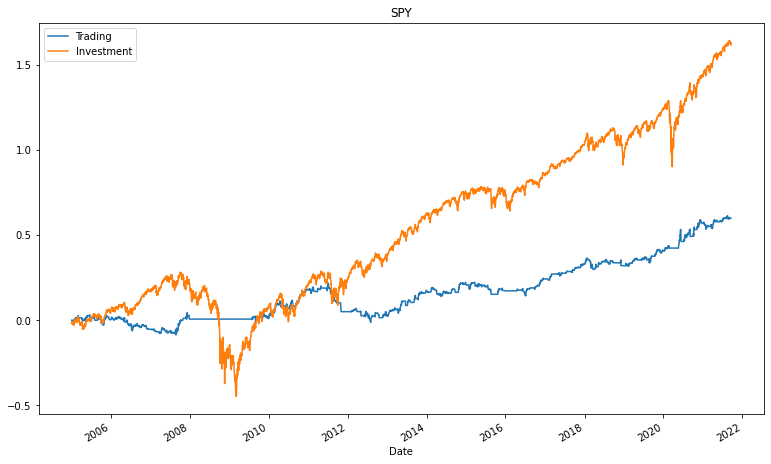

In [5]:
start_year = '2005'
end_year = None
leverage = 1

strat = daily.loc[start_year:end_year,'Combined'].shift(2) * daily.loc[start_year:,'Close'].pct_change() * leverage
buy_hold = daily.loc[start_year:end_year, 'Close'].pct_change()

plt.title(f'{ticker}')
strat.cumsum(skipna=True).plot(figsize=(13,8), label='Trading')
buy_hold.cumsum(skipna=True).plot(label='Investment')

plt.legend()
plt.show()

In [6]:
(strat.mean() / strat.std() * np.sqrt(252)) / (buy_hold.mean() / buy_hold.std() * np.sqrt(252))

1.100309339746622

## The End